In [1]:
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

import sunpy.map
from helpers import figdir
from pubtools import solar as solartools

In [2]:
data = {2: {'eis_map': 'data/ARs/total_map.fits',
            'dop_map': 'data/ARs/total_map_doppler.fits'},
        1: {'eis_map': 'data/ARs/artemp_20080110.fits',
            'dop_map': 'data/ARs/doppler_20080110.fits'}
        }

In [3]:
def load_ctr(i, m):
    fname = f'Data/open_field_contour_{i}.txt'
    ctr = np.loadtxt(fname)
    return SkyCoord(ctr[:, 0] * u.arcsec, ctr[:, 1] * u.arcsec, frame=m.coordinate_frame)

In [4]:
def set_aspect(ax, m):
    cdelt = m.wcs.wcs.cdelt
    ax.set_aspect(np.abs(cdelt[1] / cdelt[0]))

/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and 

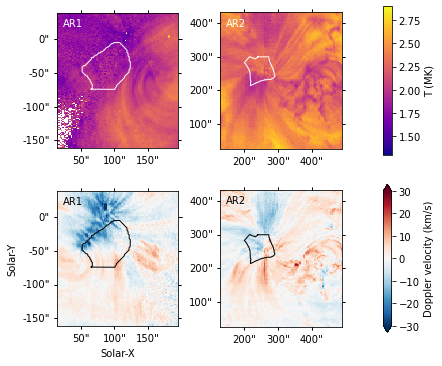

In [6]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[15, 15, 1], wspace=0.5)

axs = []
# Doppler maps
for i in [1, 2]:
    m = sunpy.map.Map(data[i]['dop_map'])
    ax = fig.add_subplot(gs[1, i-1], projection=m)
    im = m.plot(ax, cmap='RdBu_r', vmin=-30, vmax=30)
    ax.plot_coord(load_ctr(i, m), color='k', linewidth=1)
    
    set_aspect(ax, m)
    
    ax.set_title('')
    if i == 1:
        ax.set_xlabel('Solar-X')
        ax.set_ylabel('Solar-Y')
    else:
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
    ax.grid()
    axs.append(ax)


cax = fig.add_subplot(gs[1, 2])
plt.colorbar(im, cax=cax, extend='both')
cax.set_ylabel('Doppler velocity (km/s)')
    
otheraxs = []    
# Temperature maps
for i, otherax in zip([1, 2], axs):
    m = sunpy.map.Map(data[i]['eis_map'])
    ax = fig.add_subplot(gs[0, i-1], projection=m, sharex=otherax, sharey=otherax)
    im = m.plot(ax, cmap='plasma', vmin=1.3, vmax=2.9)
    ax.plot_coord(load_ctr(i, m), color='w', linewidth=1)
    set_aspect(ax, m)
    
    ax.set_title('')
    ax.grid()
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    otheraxs.append(ax)
    
for i in [1, 2]:
    otheraxs[i-1].text(0.05, 0.9, f'AR{i}', transform=otheraxs[i-1].transAxes, color='white')
    axs[i-1].text(0.05, 0.9, f'AR{i}', transform=axs[i-1].transAxes, color='black')
    
cax = fig.add_subplot(gs[0, 2])
plt.colorbar(im, cax=cax)
cax.set_ylabel('T (MK)')
    
axs[0].set_ylim(200, 400)
axs[1].set_xlim(150, 60)
axs[1].set_ylim(100, 505)

fig.savefig(f'{figdir}/ars.pdf', bbox_inches='tight')

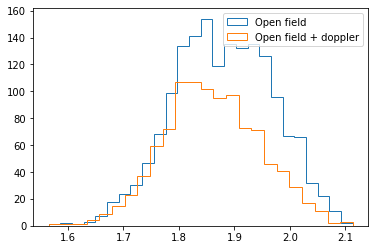

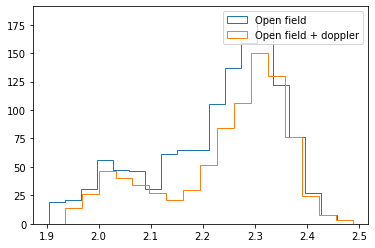

In [133]:
import importlib
importlib.reload(solartools)
for i in [1, 2]:
    m = sunpy.map.Map(data[i]['eis_map'])
    dop_m = sunpy.map.Map(data[i]['dop_map'])
    ctr = load_ctr(i, m)
    mask = solartools.contour_to_mask(ctr, m)
    
    plt.figure()
    
    temp_data = m.data[mask]
    plt.hist(temp_data, bins='auto', histtype='step', label='Open field')
    
    temp_data = m.data[mask & (dop_m.data < 0)]
    plt.hist(temp_data, bins='auto', histtype='step', label='Open field + doppler')
    plt.legend()
    
    np.save(f'data/outflow_temps_{i}.npy', temp_data)